# Part 1

## Question 1 - OIS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq, least_squares, curve_fit
pd.set_option('display.precision', 6)

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Get OIS data
data = pd.ExcelFile('IR Data.xlsx')
ois_data = pd.read_excel(data, sheet_name=1).drop(['Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5'], axis=1)

In [3]:
# Parse Tenors
def tenor_to_years(tenor):
    tenor_str = str(tenor)
    if 'm' in tenor_str:
        return int(tenor.strip('m')) / 12
    elif 'y' in tenor_str:
        return int(tenor.strip('y'))
    else:
        raise ValueError("Unrecognized tenor format")
ois_data['Tenor'] = ois_data['Tenor'].apply(tenor_to_years)
ois_data = pd.DataFrame(np.arange(1, 31), columns=['Tenor']).merge(ois_data, on='Tenor', how='outer').sort_values('Tenor').reset_index(drop=True)

# Introduce and format new columns
ois_data['OIS Forward Rate'] = np.nan
ois_data['OIS Discount Factor'] = np.nan
ois_data.rename(columns={'Product': 'OIS Table Product', 'Rate': 'OIS Rate'}, inplace=True)

To get first forward rate $f_o(0, 6m)$, we use the formula:
$$PV_{\text{fix}}^{6mOIS} = PV_{\text{flt}}^{6mOIS}$$
$$D_o(0, 6m) \times 0.5 \times 0.0025 = D_o(0, 6m) \times \left[\left(1 + \frac{f_o(0, 6m)}{360}\right)^{180} - 1\right]$$
Then we can solve for $D_o(0, 6m)$ using $f_o(0, 6m)$

In [4]:
# Constants
days_per_year = 360

# Calculate the first forward rate using the 6-month OIS rate
ois_data.at[0, 'OIS Forward Rate'] = (((1 + (0.5 * ois_data.at[0, 'OIS Rate'])) ** (1 / (ois_data.at[0, 'Tenor'] * days_per_year))) - 1) * days_per_year

# Calculate the first discount factor using the computed forward rate
ois_data.at[0, 'OIS Discount Factor'] = (1 / (1 + (ois_data.at[0, 'OIS Forward Rate'] / days_per_year))) ** (ois_data.at[0, 'Tenor'] * days_per_year)

To get the second forward rate $f_o(6m, 1y)$, we use the formula:
$$PV_{\text{fix}}^{1yOIS} = PV_{\text{flt}}^{1yOIS}$$
$$
D_o(0, 1y) \times 0.003 = D_o(0, 1y) \times \left[\left(1 + \frac{f_o(0, 6m)}{360}\right)^{180}\left(1 + \frac{f_o(6m, 1y)}{360}\right)^{180} - 1\right]
$$
Then we can solve for $D_o(0, 1y)$ using $f_o(0, 6m)$ and $f_o(6m, 1y)$

In [5]:
# Calculate the second forward rate using the 1-year OIS rate and the first forward rate
ois_data.at[1, 'OIS Forward Rate'] = (((1 + ois_data.at[1, 'OIS Rate']) / 
                        ((1 + ois_data.at[0, 'OIS Forward Rate'] / days_per_year) ** 180)) ** (1 / 180) - 1) * days_per_year
# Calculate the second discount factor using the first and second forward rates
ois_data.at[1, 'OIS Discount Factor'] = ((1 / (1 + ( ois_data.at[0, 'OIS Forward Rate'] / days_per_year))) ** 180) * ((1 / (1 + (ois_data.at[1, 'OIS Forward Rate'] / days_per_year))) ** 180)

To get subsequent forward rates, we use the generalised formula:
$$
\prod_{i=1}^{N} \left(1 + \Delta_{i-1} f_o(T_{i-1}, T_i)\right) = 1 + \Delta S_0
$$
and equating the fixed and floating legs at each tenor:
$$PV_{\text{fix}}^{OIS} = PV_{\text{flt}}^{OIS}$$

In [6]:
def ois_df(x, i, h, ois_data, fix, flt):
    # Calculate the difference between the previous discount factor and current discount factor flt_df
    flt_x = ois_data.at[i-1, 'OIS Discount Factor'] - x
    flx_dis_x = 0
    # Generate an array of interpolated discount factors using linear interpolation
    interpolated_discounts = x + (np.arange(h-i+1)/(h-i+1)) * flt_x
    
    # Sum up the interpolated discount factors to get the fixed leg discounted sum
    fix_dis_x = np.sum(interpolated_discounts)
    
    # Calculate the fixed leg payment
    fix_x = fix_dis_x * ois_data['OIS Rate'][h]
    
    # Return the difference between fixed and floating leg payments, adjusted by flt_x
    return fix_x + fix - flt_x - flt

In [7]:
i = 2
while i <= 30:
    h = i
    while np.isnan(ois_data['OIS Rate'][h]):
        h += 1
    k = 1
    fix = 0
    while k < i:
        fix_i = ois_data.at[k, 'OIS Discount Factor']*ois_data.at[h, 'OIS Rate']
        fix += fix_i
        k+=1

        # Calculate fixed and floating payments
    flt = ois_data['OIS Rate'][i-1]*ois_data['OIS Discount Factor'][1:i].sum()
        
        # Define the function for Brent's method
    f = lambda x: (ois_df(x, i, h, ois_data, fix, flt))
        
        # Use Brent's method to find the discount factor
    D_l = brentq(f, 0, 1)

        # Update discount factors and forward rates for the range [i, h]
    for n in range(0, h-i+1):
        df_index = i + n
        ois_data.at[i+n, 'OIS Discount Factor'] = D_l + ((h-i-n)/(h-i+1))*(ois_data.at[i-1, 'OIS Discount Factor'] - D_l)
        ois_data.at[i+n, 'OIS Forward Rate'] = 360*((ois_data.at[i+n-1, 'OIS Discount Factor'] / ois_data.at[i+n, 'OIS Discount Factor'])**(1/360)-1)

        # Advance to the next tenor after the last non-NaN rate
    i = h + 1

In [8]:
ois_data_final = ois_data.dropna()
ois_data_final

,Tenor,OIS Table Product,OIS Rate,OIS Forward Rate,OIS Discount Factor
0,0.5,OIS,0.00250,0.002498,0.998752
1,1.0,OIS,0.00300,0.003493,0.997009
2,2.0,OIS,0.00325,0.003495,0.993531
3,3.0,OIS,0.00335,0.003545,0.990015
4,4.0,OIS,0.00350,0.003946,0.986117
5,5.0,OIS,0.00360,0.003996,0.982184
7,7.0,OIS,0.00400,0.005015,0.972406
10,10.0,OIS,0.00450,0.005712,0.955977
15,15.0,OIS,0.00500,0.006097,0.927611
20,20.0,OIS,0.00525,0.006100,0.900076


In [9]:
terms = np.linspace(0, 30, 1200)
from scipy.interpolate import CubicSpline

# Create a cubic spline function based on the tenor and discount factors
cs = CubicSpline(ois_data['Tenor'].values, ois_data['OIS Discount Factor'].values)

# Evaluate the spline function over the range of terms to get interpolated discount factors
interpolated_discount_factors = cs(terms)

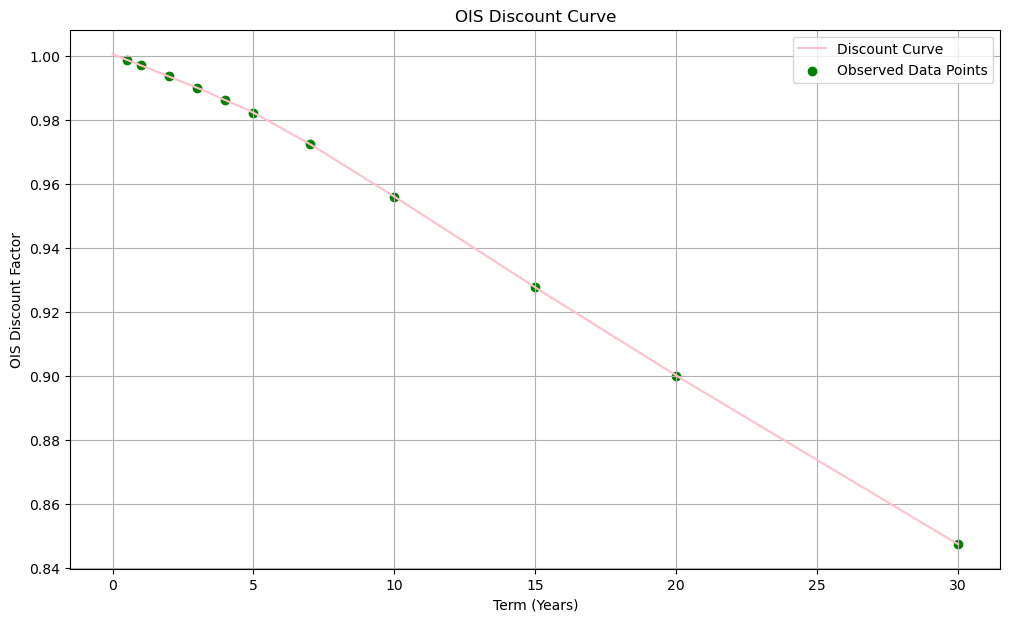

In [10]:
plt.figure(figsize=(12, 7))
plt.plot(terms, interpolated_discount_factors, label='Discount Curve', color='pink')
plt.scatter(ois_data_final['Tenor'], ois_data_final['OIS Discount Factor'], color='green', label='Observed Data Points')
plt.title('OIS Discount Curve')
plt.xlabel('Term (Years)')
plt.ylabel('OIS Discount Factor')
plt.legend()
plt.grid(True)
plt.show()

## Question 2

In [11]:
# Get IRS data
irs_data = pd.read_excel(data, sheet_name=0)
irs_data = irs_data.drop(['Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5'], axis=1)

In [12]:
# Parse Tenors
def tenor_to_years(tenor):
    tenor_str = str(tenor)
    if 'm' in tenor_str:
        return int(tenor.strip('m')) / 12
    elif 'y' in tenor_str:
        return int(tenor.strip('y'))
    else:
        raise ValueError("Unrecognized tenor format")
irs_data['Tenor'] = irs_data['Tenor'].apply(tenor_to_years)
irs_data = pd.DataFrame(np.arange(0.5, 30.5, 0.5), columns=['Tenor']).merge(irs_data, on='Tenor', how='outer').sort_values('Tenor').reset_index(drop=True)
ois_data_final = pd.DataFrame(np.arange(0.5, 30.5, 0.5), columns=['Tenor']).merge(ois_data_final, on='Tenor', how='outer').sort_values('Tenor').reset_index(drop=True)
oisirs_data = pd.merge(ois_data_final, irs_data, on = 'Tenor', how = 'left')

# Introduce new columns
oisirs_data['LIBOR Forward Rate'] = np.nan
oisirs_data['LIBOR Discount Factor'] = np.nan
oisirs_data.rename(columns={'Product': 'IRS Table Product', 'Rate': 'IRS Rate'}, inplace=True)

 Given forward LIBOR rate $L(0, 6m)$, we use the formula:
$$ D(0, 6m) = \frac{1}{1+0.5*L(0,6m)}$$
to solve for first discount factor $D(0, 6m)$

In [13]:
# Get the first forward rate using the 6-month LIBOR IRS rate
oisirs_data.at[0, 'LIBOR Forward Rate'] = oisirs_data.at[0,'IRS Rate']

# Calculate the first discount factor using the computed forward rate
oisirs_data.at[0, 'LIBOR Discount Factor'] = 1 / (1 + oisirs_data.at[0, 'IRS Rate'] * (oisirs_data.at[0, 'Tenor']))

To get the second forward LIBOR rate $L(6m, 1y)$, we use the formula:
$$PV_{\text{fix}}^{2yIRS} = PV_{\text{flt}}^{2yIRS}$$
$$
0.5 \times 0.025 \times [D_o(0, 6m) + D_o(0, 1y)]= 0.5 \times [(D_o(0, 6m) \times L(0, 6m)) + (D_o(0, 1y) \times L(6m, 1y))]
$$
Then we can solve for $D(0, 1y)$ using $L(6m, 1y)$

In [14]:
# Calculate the second forward rate using the 1-year OIS discount rate and the first forward rate
oisirs_data.at[1, 'LIBOR Forward Rate'] =  (oisirs_data.at[1,'IRS Rate'] * (oisirs_data.at[0,'OIS Discount Factor'] + oisirs_data.at[1,'OIS Discount Factor']) - (oisirs_data.at[0,'LIBOR Forward Rate'] * oisirs_data.at[0,'OIS Discount Factor'])) / oisirs_data.at[1,'OIS Discount Factor']

# Calculate the second discount factor using the first and second forward rates
oisirs_data.at[1, 'LIBOR Discount Factor'] = (1 / (1 + oisirs_data.at[0, 'Tenor'] * oisirs_data.at[0, 'LIBOR Forward Rate'])  * (1 / (1 + oisirs_data.at[0, 'Tenor'] * oisirs_data.at[1, 'LIBOR Forward Rate'])))
oisirs_data['OIS Discount Factor'].interpolate(method = 'linear', inplace = True)

To get subsequent forward LIBOR and discount rates, we use the generalised formula:
$$
K \sum_{i=1}^{n} \Delta_{i-1} D(0, T_i) = \sum_{i=1}^{n} D(0, T_i) \Delta_{i-1} L(T_{i-1}, T_i)
$$
which equates the fixed and floating legs at each tenor:
$$PV_{\text{fix}}^{IRS} = PV_{\text{flt}}^{IRS}$$

In [15]:
def libor_df(x):
    df_diff = oisirs_data['LIBOR Discount Factor'][i-2] - x
    df_p = [oisirs_data['LIBOR Discount Factor'][i-2]]
    libor_payment = []
    for n in range(0, h-i+2):
        df_c = x + ((h - i - n + 1)/(h - i + 2)) * df_diff
        libor = 0.5 * (2 * (df_p[-1] - df_c) / df_c) * oisirs_data['OIS Discount Factor'][i-1+n]
        df_p.append(df_c)
        libor_payment.append(libor)
    flt_x = sum(libor_payment)
    return flt_x + flt - fix

In [16]:
i = 3
while i <= 60:
    h = i
    # Ensure h is within the DataFrame index range
    while np.isnan(oisirs_data['IRS Rate'][h]):
        h += 2
    fix = 0.5 * oisirs_data['IRS Rate'][h] * oisirs_data['OIS Discount Factor'][0 : h + 1].sum()
    flt = 0
    k = 0
    while k <= i-2:
        flt_i = 0.5 * oisirs_data['OIS Discount Factor'][k] * oisirs_data['LIBOR Forward Rate'][k]
        flt += flt_i
        k += 1
        
    f = lambda x: libor_df(x)
    df_libor = brentq(f, 0, 1)
    for n in range(0, h - i + 2):
#         if i-1+n < len(oisirs_data):  # Ensure the index is within the DataFrame
            oisirs_data['LIBOR Discount Factor'][i-1+n] = df_libor + ((h- i - n + 1)/(h -i + 2))*(oisirs_data['LIBOR Discount Factor'][i-2] - df_libor)
            oisirs_data['LIBOR Forward Rate'][i-1+n] = (oisirs_data['LIBOR Discount Factor'][i - 2 + n] - oisirs_data['LIBOR Discount Factor'][i - 1 + n]) / (0.5 * oisirs_data['LIBOR Discount Factor'][i - 1 + n])
    i = h + 2

In [17]:
oisirs_data_final = oisirs_data.dropna()
oisirs_data_final

,Tenor,OIS Table Product,OIS Rate,OIS Forward Rate,OIS Discount Factor,IRS Table Product,IRS Rate,LIBOR Forward Rate,LIBOR Discount Factor
0,0.5,OIS,0.00250,0.002498,0.998752,LIBOR,0.0250,0.025000,0.987654
1,1.0,OIS,0.00300,0.003493,0.997009,IRS,0.0280,0.031005,0.972577
3,2.0,OIS,0.00325,0.003495,0.993531,IRS,0.0300,0.032263,0.942179
5,3.0,OIS,0.00335,0.003545,0.990015,IRS,0.0315,0.034814,0.910482
7,4.0,OIS,0.00350,0.003946,0.986117,IRS,0.0325,0.035838,0.878981
9,5.0,OIS,0.00360,0.003996,0.982184,IRS,0.0330,0.035326,0.848989
13,7.0,OIS,0.00400,0.005015,0.972406,IRS,0.0350,0.041298,0.784216
19,10.0,OIS,0.00450,0.005712,0.955977,IRS,0.0370,0.044033,0.692710
29,15.0,OIS,0.00500,0.006097,0.927611,IRS,0.0400,0.051401,0.551081
39,20.0,OIS,0.00525,0.006100,0.900076,IRS,0.0450,0.069994,0.408218


In [18]:
oisirs_data_final.to_excel("transformed_data.xlsx", index=False)

In [19]:
terms = np.linspace(0, 30, 1200)
from scipy.interpolate import CubicSpline

# Create a cubic spline function based on the tenor and discount factors
cs = CubicSpline(oisirs_data_final['Tenor'].values, oisirs_data_final['LIBOR Discount Factor'].values)

# Evaluate the spline function over the range of terms to get interpolated discount factors
interpolated_discount_factors = cs(terms)

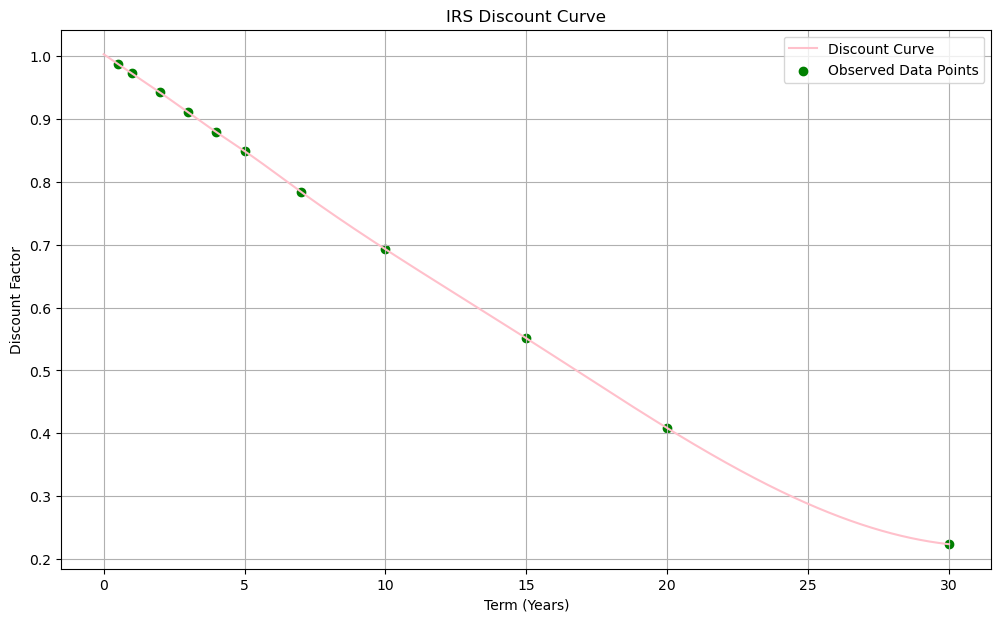

In [20]:
plt.figure(figsize=(12, 7))
plt.plot(terms, interpolated_discount_factors, label='Discount Curve', color='pink')
plt.scatter(oisirs_data_final['Tenor'], oisirs_data_final['LIBOR Discount Factor'], color='green', label='Observed Data Points')
plt.title('IRS Discount Curve')
plt.xlabel('Term (Years)')
plt.ylabel('Discount Factor')
plt.legend()
plt.grid(True)
plt.show()

## Question 3

To calculate the par swap rate, we use the formula: 
$$ S(T_i,T_{i+m}) = \frac{0.5*\sum_{n=i+1}^{i+m} {D_o(0,T_n)*L(T_{n-0.5},T_n)}}{0.5*\sum_{n=i+1}^{i+m} D_o(0,T_n)}$$

In [21]:
expiry = ['1Y', '5Y', '10Y']
tenors = ['1Y', "2Y", '3Y', '5Y', '10Y']

In [22]:
par_swap_rate = []
for expiries in expiry:
    for tenor in tenors:
        # Remove 'Y'
        i = int(expiries.strip()[:-1]) 
        j = int(tenor.strip()[:-1])
        
        fix = 0.5*sum(oisirs_data['OIS Discount Factor'][2*i:2*(i+j)])
        
        terms = []
        for x in range(2*i, 2*(i+j)):
            flt = oisirs_data['OIS Discount Factor'][x] * (oisirs_data['LIBOR Discount Factor'][x-1] - oisirs_data['LIBOR Discount Factor'][x])/oisirs_data['LIBOR Discount Factor'][x]
            terms.append(flt)
        flt_payment = sum(terms)
        
        par_swap_rate.append(flt_payment/fix)

In [23]:
par_swap_rate_table = np.array(par_swap_rate).reshape(3, 5)
par_swap_rate = pd.DataFrame(par_swap_rate_table, columns = tenors, index = expiry)
par_swap_rate

,1Y,2Y,3Y,5Y,10Y
1Y,0.032007,0.033259,0.034011,0.035255,0.038428
5Y,0.039274,0.040075,0.040072,0.041093,0.043634
10Y,0.042189,0.043116,0.044097,0.046249,0.053458


In [ ]:
par_swap_rate.to_csv("par_swap_rate.csv")